Epoch 1/50


/Users/dogukankorkut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.4406 - loss: 1.2663 - val_accuracy: 0.6743 - val_loss: 0.7222
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6311 - loss: 0.8451 - val_accuracy: 0.7418 - val_loss: 0.6180
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.7049 - loss: 0.7222 - val_accuracy: 0.7682 - val_loss: 0.5787
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.7377 - loss: 0.6826 - val_accuracy: 0.7999 - val_loss: 0.5327
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.7465 - loss: 0.6547 - val_accuracy: 0.8063 - val_loss: 0.5133
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.7785 - loss: 0.6174 - val_accuracy: 0.8046 - val_loss: 0.5074
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.7868 - loss: 0.5919 - val_accuracy: 0.8192 - val_loss: 0.4778
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.7899 - loss: 0.5676 - val_accurac

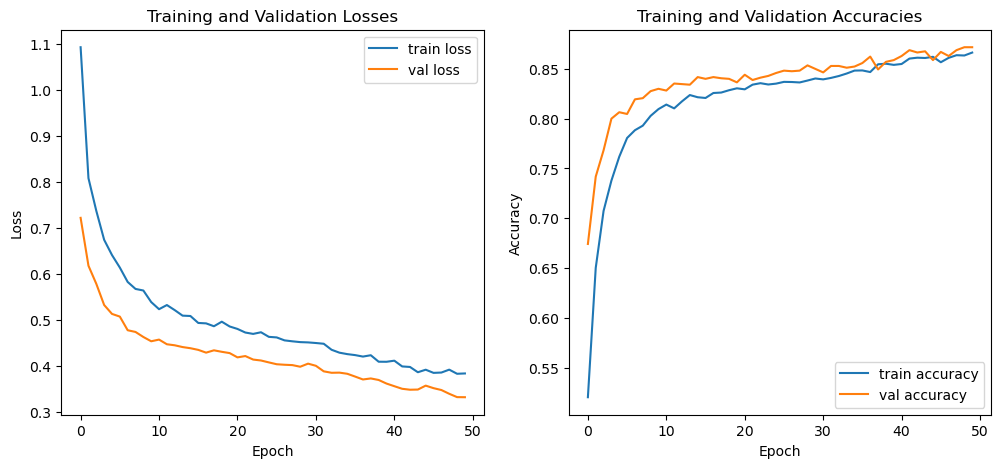

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


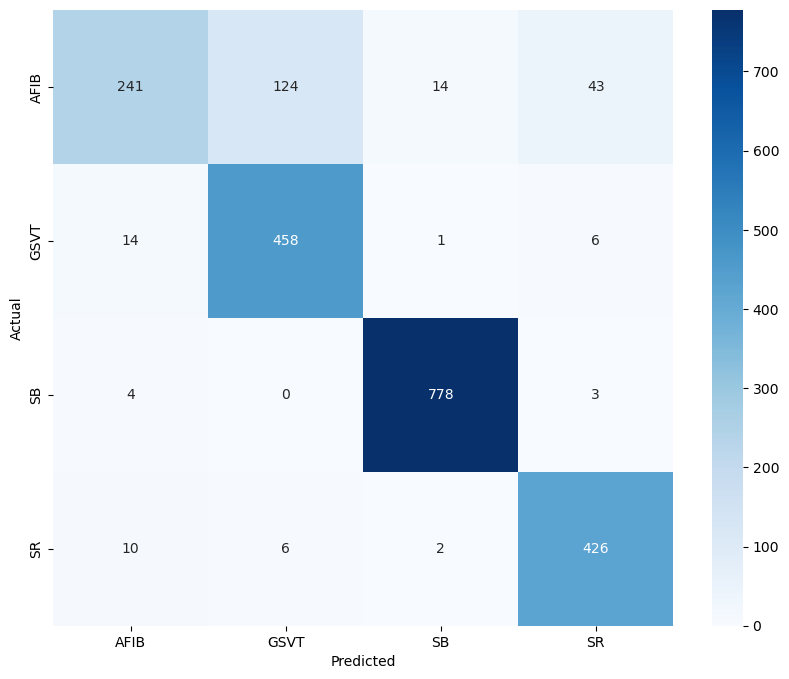

Classification Report:
              precision    recall  f1-score   support

        AFIB       0.90      0.57      0.70       422
        GSVT       0.78      0.96      0.86       479
          SB       0.98      0.99      0.98       785
          SR       0.89      0.96      0.92       444

    accuracy                           0.89      2130
   macro avg       0.89      0.87      0.87      2130
weighted avg       0.90      0.89      0.89      2130

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted Rhythm for file MUSE_20180111_155115_19000: GSVT


/Users/dogukankorkut/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

# Load the dataset
df = pd.read_csv('FeatureExtractionParameters.csv', delimiter=';')

# Clean column names
df.columns = df.columns.str.strip()

# Merge target variable categories
df['MergedRhythm'] = np.where(df['Rhythm'].isin(['AF', 'AFIB']), 'AFIB',
                               np.where(df['Rhythm'].isin(['SVT', 'AT', 'SAAWR', 'ST', 'AVNRT', 'AVRT']), 'GSVT',
                                        np.where(df['Rhythm'].isin(['SA', 'SR']), 'SR', 'SB')))

# Save FileName column separately
file_names = df['FileName']

# Drop unnecessary columns
df.drop(columns=['FileName', 'Beat', 'PatientAge', 'Gender', 'Rhythm'], inplace=True)

# Prepare X and y variables
X = df.drop(columns=['MergedRhythm']).values
y = df['MergedRhythm'].values

# Convert categorical data to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)  # One-hot encoding

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8),dpi=500)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Predict for a specific file
file_name = 'MUSE_20180111_155115_19000'

# Find the specified file and prepare its data
selected_file_index = file_names[file_names == file_name].index
if len(selected_file_index) > 0:
    selected_file = df.loc[selected_file_index].drop(columns=['MergedRhythm'])
    selected_file_scaled = scaler.transform(selected_file)
    prediction = model.predict(selected_file_scaled)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)
    print(f'Predicted Rhythm for file {file_name}: {predicted_label[0]}')
else:
    print(f'File {file_name} not found in the dataset.')
